#                                                  Product recommender System 

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

#### Step-1 Data Loading and preprocessing.

In [118]:
train_data = pd.read_csv('marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv',sep='\t')
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [119]:

train_data = train_data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]

train_data.head(3)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...


In [120]:
## if we rename a specific column 
train_data.rename(columns={
    'Uniq Id': 'UserID',
    'Product Id': 'ProductID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags'
}, inplace=True)


In [121]:
## renamae all columns in single way

# df.columns = [
#     'UniqueID', 'ProductID', 'Rating', 'ReviewCount', 'Category',
#     'Brand', 'Name', 'ImageURL', 'Description', 'Tags'
# ]


In [122]:
print(train_data.columns)



Index(['UserID', 'ProductID', 'Rating', 'ReviewCount', 'Category', 'Brand',
       'Name', 'ImageURL', 'Description', 'Tags'],
      dtype='object')


### Operations

In [123]:
train_data['Tags']

0       OPI Infinite Shine, Nail Lacquer Nail Polish, ...
1       Nice 'n Easy Permanent Color, 111 Natural Medi...
2       Clairol Nice 'N Easy Permanent Color 7/106A Na...
3       Kokie Professional Matte Lipstick, Hot Berry, ...
4       Gillette TRAC II Plus Razor Blade Refills, Fit...
                              ...                        
4995    Garden Mint Room Spray (Double Strength), 4 ou...
4996    Garnier Nutrisse Nourishing Hair Color Creme (...
4997    Nail File Electric Drill, 6 in 1 Professional ...
4998    Creed Love In Black Hair And Body Wash 6.8oz/2...
4999                    Foundation, Wal-mart, Walmart.com
Name: Tags, Length: 5000, dtype: object

In [124]:
train_data.isnull().sum()

UserID            0
ProductID         0
Rating         2806
ReviewCount    1654
Category         10
Brand            13
Name              0
ImageURL          0
Description    1127
Tags              0
dtype: int64

In [125]:
## Fill missing values in DATA 

# inplace=True	Changes are applied to the original DataFrame
# inplace=False	A new DataFrame is returned, and the original stays the same

# fill product rating & reviews with default value 0
train_data['Rating'].fillna(0, inplace=True)
train_data['ReviewCount'].fillna(0, inplace=True)

# fill For text/categorical columns
train_data['Category'].fillna('Unknown', inplace=True)
train_data['Brand'].fillna('Unknown', inplace=True)
train_data['Description'].fillna('No description', inplace=True)


C:\Users\saqib\AppData\Local\Temp\ipykernel_9460\1161109782.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Rating'].fillna(0, inplace=True)
C:\Users\saqib\AppData\Local\Temp\ipykernel_9460\1161109782.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

In [126]:
## check value alls are fill or not
train_data.isnull().sum()

UserID         0
ProductID      0
Rating         0
ReviewCount    0
Category       0
Brand          0
Name           0
ImageURL       0
Description    0
Tags           0
dtype: int64

In [127]:
## chack duplicate
train_data.duplicated().sum()

0

In [128]:
## use this because of change id readable
train_data['UserID'] = train_data['UserID'].str.extract(r'(\d+)').astype(float)
train_data['ProductID'] = train_data['ProductID'].str.extract(r'(\d+)').astype(float)


### Step-2 EDA (Exploratory Data Analysis)

In [129]:
#Basic statistics
num_users = train_data['UserID'].nunique()
num_items = train_data['ProductID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")


Number of unique users: 1721
Number of unique items: 1697
Number of unique ratings: 36


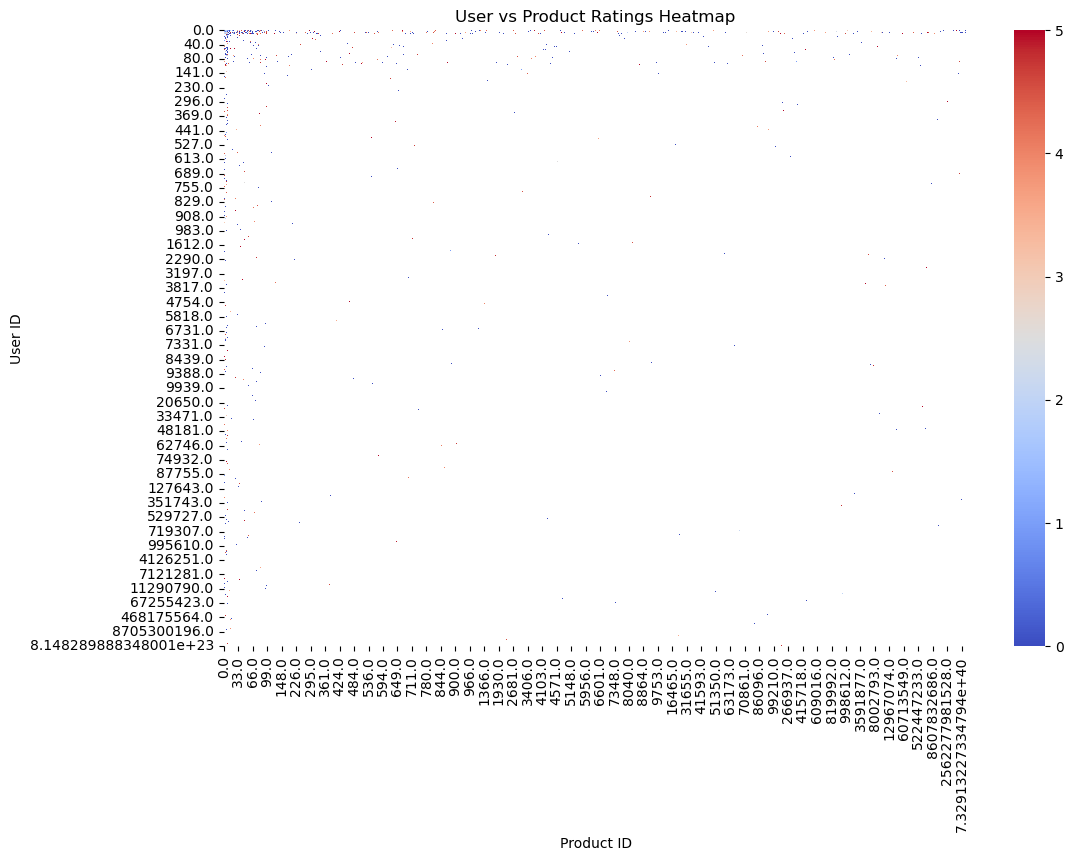

In [130]:
heatmap_data = train_data.pivot_table(
    values='Rating',
    index='UserID',
    columns='ProductID'
)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', cbar=True)
plt.title('User vs Product Ratings Heatmap')
plt.xlabel('Product ID')
plt.ylabel('User ID')
plt.show()


"Distribution of Interaction" in a recommendation system context usually means:
How many times users interact with products — for example, how many ratings, clicks, views, or purchases happen per user or per product.

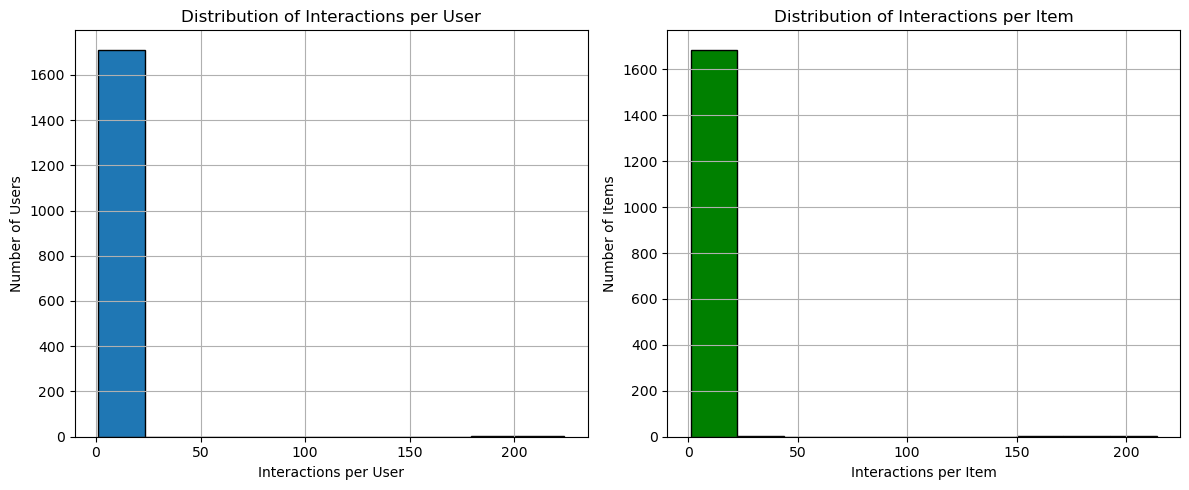

In [131]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['UserID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProductID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

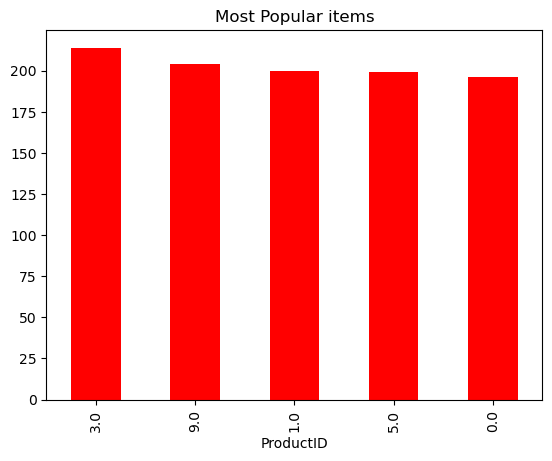

In [132]:
# Most popular items
popular_items = train_data['ProductID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

<Axes: xlabel='Rating'>

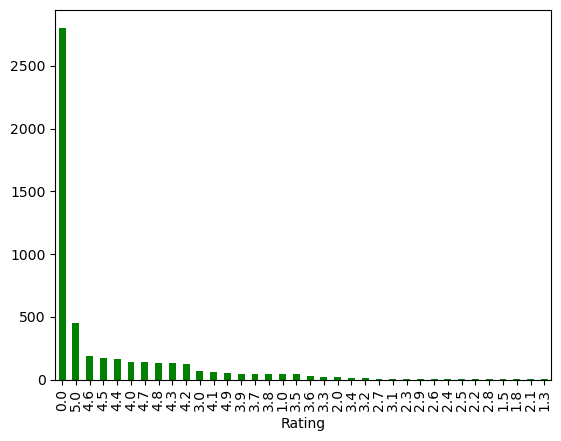

In [133]:

# most rated counts
train_data['Rating'].value_counts().plot(kind='bar',color='green')

## ADDING .....
 

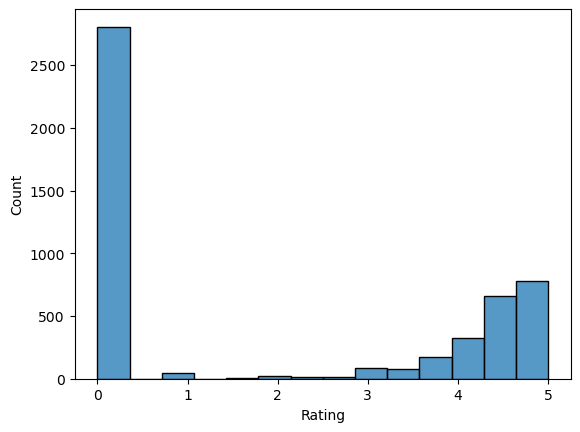

In [134]:
sns.histplot(train_data['Rating'])
plt.show()

In [135]:
train_data.shape        # Rows and columns
train_data.info()       # Column types & non-null counts
train_data.describe()   # Summary statistics for numeric columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   UserID       5000 non-null   float64
 1   ProductID    5000 non-null   float64
 2   Rating       5000 non-null   float64
 3   ReviewCount  5000 non-null   float64
 4   Category     5000 non-null   object 
 5   Brand        5000 non-null   object 
 6   Name         5000 non-null   object 
 7   ImageURL     5000 non-null   object 
 8   Description  5000 non-null   object 
 9   Tags         5000 non-null   object 
dtypes: float64(4), object(6)
memory usage: 390.8+ KB


,UserID,ProductID,Rating,ReviewCount
count,5.000000e+03,5.000000e+03,5000.000000,5000.000000
mean,1.629720e+20,1.950749e+40,1.884480,382.137000
std,1.152342e+22,2.312394e+41,2.192057,2050.994303
min,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,6.000000e+00,6.000000e+00,0.000000,0.000000
50%,4.700000e+01,5.600000e+01,0.000000,3.000000
75%,8.702500e+02,1.405250e+03,4.400000,60.250000
max,8.148290e+23,5.005509e+42,5.000000,29242.000000


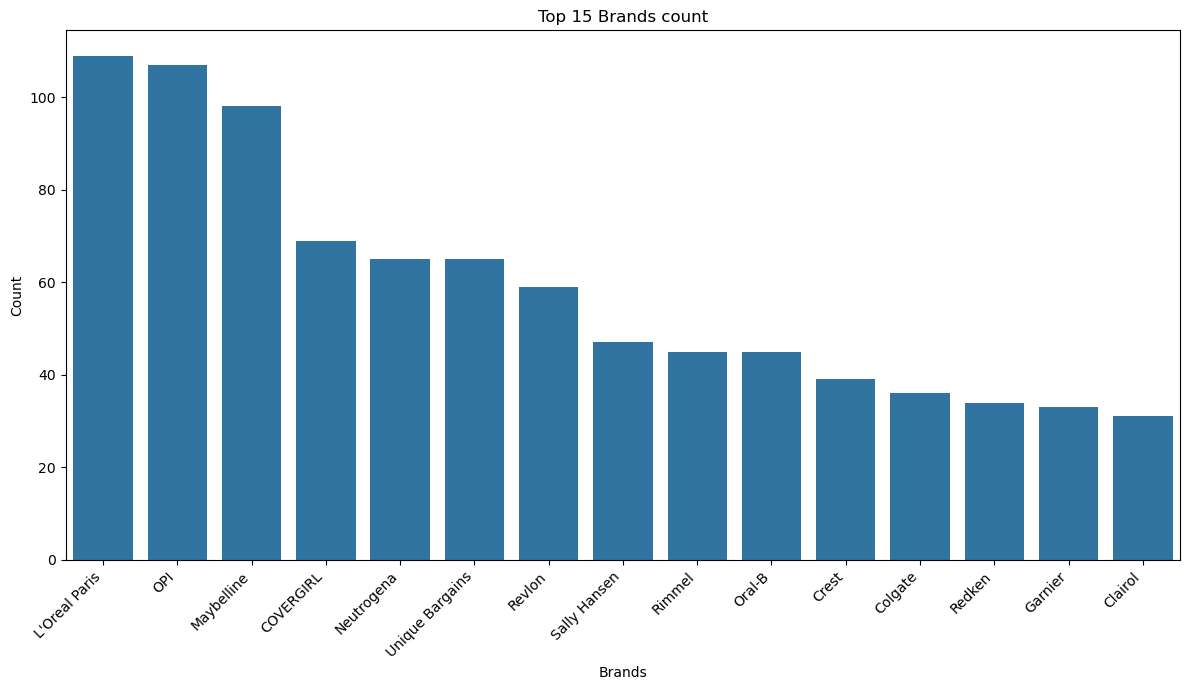

In [137]:
# count every brand
brand_counts = train_data['Brand'].value_counts()

# Top N brands   ##here is 15 taken
top_n = 15
top_brands = brand_counts.nlargest(top_n).index

# filter only top n data
train_data_top_brands = train_data[train_data['Brand'].isin(top_brands)]

# 4. make the Plot 
plt.figure(figsize=(12, 7)) # Plot ka size thoda bada karein
sns.countplot(data=train_data_top_brands, x='Brand', order=top_brands)
plt.xticks(rotation=45, ha='right')
plt.title(f'Top {top_n} Brands count')
plt.xlabel('Brands')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Step-3 data cleaning and tags creation


In [138]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags)

In [139]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

In [140]:
print(train_data[['Category', 'Brand', 'Description']].head(1))


                                            Category Brand  Description
0  premium, beauty, premium, makeup, premium, nai...   opi  description
